# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [60]:
#! pip install -U yfinance pandas numpy matplotlib lightgbm

### Importing Required Libraries

In [61]:
from datetime import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

### Variables

In [62]:
print_errors = False
build_new_dataset = False
symbols = 'advanced' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'

## Data Preparation

In [63]:
if symbols == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbols == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['A', 'AA', 'AAT', ..., 'ZEUS', 'ZION', 'ZUMZ'],
      shape=(1566,), dtype=object)

#### Download annual financial data

In [64]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        try:
            ticker_df = pd.DataFrame()
            ticker = yf.Ticker(symbol)
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()

            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
        
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:
                        earning_date_data['1 Year Future Change'] = float(price_data.loc[earning_date + pd.Timedelta(days=day_offset+365,), ('Close', symbol)]) / float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        got_price = True
                    except Exception:
                        day_offset += -1
                
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            imputer = SimpleImputer()
            wanted_columns = ticker_df.columns.drop(['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'])
            for column in wanted_columns:
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])

            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    wanted_columns = df.columns.drop(['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'])
    for column in wanted_columns:
        df[column] = imputer.fit_transform(df[[column]])
        scaler = StandardScaler()
        scaler.fit(df[[column]])
        df[column] = scaler.transform(df[[column]])

    le = LabelEncoder()
    for non_numeric_column in ['Sector', 'Industry']:
        df[non_numeric_column] = df[non_numeric_column].astype(str)
        le.fit(df[non_numeric_column])
        df[non_numeric_column] = le.transform(df[non_numeric_column])

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [65]:
df

,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Restricted Common Stock,Net Income From Tax Loss Carryforward
0,AA,2023-12-31,0.103476,0,5,-0.022618,0.075749,0.059613,-0.061755,0.063339,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
1,AA,2022-12-31,-0.261057,0,5,-0.021928,0.053653,0.059634,-0.061787,0.063386,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
2,AA,2021-12-31,-0.226370,0,5,-0.021762,0.069120,0.059256,-0.061659,0.063468,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
3,AA,2020-12-31,1.590461,0,5,-0.022103,0.066174,0.059501,-0.061734,0.063398,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4,AAT,2023-12-31,0.202075,8,96,-0.022136,0.000000,0.059580,-0.061729,0.063749,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4961,ZBRA,2020-12-31,0.548669,9,25,-0.021838,0.063081,0.059557,-0.061634,0.063758,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4962,ZUMZ,2024-01-31,-0.050670,2,7,-0.022235,0.075749,0.059620,-0.061775,0.063807,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4963,ZUMZ,2023-01-31,-0.335269,2,7,-0.022253,0.071866,0.059627,-0.061782,0.063802,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4964,ZUMZ,2022-01-31,-0.425362,2,7,-0.022124,0.067185,0.059634,-0.061788,0.063811,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0


### Splitting and normalization

In [66]:
test_data = df.loc[df.groupby('Ticker')['Date'].idxmax()]
training_data = df[~df.index.isin(test_data.index)]

display(test_data)
display(training_data)

,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Restricted Common Stock,Net Income From Tax Loss Carryforward
0,AA,2023-12-31,0.103476,0,5,-0.022618,0.075749,0.059613,-0.061755,6.333941e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4,AAT,2023-12-31,0.202075,8,96,-0.022136,0.000000,0.059580,-0.061729,6.374942e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
8,ABM,2023-10-31,0.390643,7,122,-0.022061,0.069646,0.059301,-0.061480,6.377723e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
12,ABR,2023-12-31,-0.023103,8,100,-0.022022,0.074095,0.056471,-0.059374,1.396429e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
16,ABT,2023-12-31,0.062362,6,76,-0.017765,0.021525,0.058904,-0.061788,6.181017e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,YORW,2023-12-31,-0.142838,11,141,-0.022259,0.000000,0.059615,-0.061761,6.376564e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4950,YY,2023-12-31,0.072372,1,68,-0.022041,0.063645,0.059484,-0.061763,6.375031e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4954,Z,2023-12-31,0.294478,1,68,-0.022063,0.057012,0.059618,-0.061774,6.367436e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4958,ZBRA,2023-12-31,0.413002,9,25,-0.022310,0.073451,0.059562,-0.061673,6.374574e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0


,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Restricted Common Stock,Net Income From Tax Loss Carryforward
1,AA,2022-12-31,-0.261057,0,5,-0.021928,0.053653,0.059634,-0.061787,0.063386,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
2,AA,2021-12-31,-0.226370,0,5,-0.021762,0.069120,0.059256,-0.061659,0.063468,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
3,AA,2020-12-31,1.590461,0,5,-0.022103,0.066174,0.059501,-0.061734,0.063398,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
5,AAT,2022-12-31,-0.100890,8,96,-0.022172,0.000000,0.059602,-0.061759,0.063721,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
6,AAT,2021-12-31,-0.263050,8,96,-0.022173,0.000000,0.059559,-0.061659,0.063730,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,ZBRA,2021-12-31,-0.570891,9,25,-0.021338,0.073230,0.059545,-0.061776,0.063771,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4961,ZBRA,2020-12-31,0.548669,9,25,-0.021838,0.063081,0.059557,-0.061634,0.063758,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4963,ZUMZ,2023-01-31,-0.335269,2,7,-0.022253,0.071866,0.059627,-0.061782,0.063802,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4964,ZUMZ,2022-01-31,-0.425362,2,7,-0.022124,0.067185,0.059634,-0.061788,0.063811,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0


In [67]:
X_train = training_data.drop(columns=['Ticker', 'Date', '1 Year Future Change'])
y_train = training_data['1 Year Future Change']
X_test = test_data.drop(columns=['Ticker', 'Date', '1 Year Future Change'])
y_test = test_data['1 Year Future Change']

display(X_train)
display(y_train)

,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,Effect Of Exchange Rate Changes,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Restricted Common Stock,Net Income From Tax Loss Carryforward
1,0,5,-0.021928,0.053653,0.059634,-0.061787,0.063386,-0.067192,-0.065839,-1.102933e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
2,0,5,-0.021762,0.069120,0.059256,-0.061659,0.063468,-0.067000,-0.065981,-1.104258e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
3,0,5,-0.022103,0.066174,0.059501,-0.061734,0.063398,-0.067189,-0.065954,-1.101277e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
5,8,96,-0.022172,0.000000,0.059602,-0.061759,0.063721,-0.067801,-0.066643,-1.579427e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
6,8,96,-0.022173,0.000000,0.059559,-0.061659,0.063730,-0.067763,-0.066643,-1.579427e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,9,25,-0.021338,0.073230,0.059545,-0.061776,0.063771,-0.067680,-0.066620,-1.099952e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4961,9,25,-0.021838,0.063081,0.059557,-0.061634,0.063758,-0.067741,-0.066608,-1.099952e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4963,2,7,-0.022253,0.071866,0.059627,-0.061782,0.063802,-0.067785,-0.066650,-1.100672e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4964,2,7,-0.022124,0.067185,0.059634,-0.061788,0.063811,-0.067769,-0.066670,-1.100556e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0


1      -0.261057
2      -0.226370
3       1.590461
5      -0.100890
6      -0.263050
          ...   
4960   -0.570891
4961    0.548669
4963   -0.335269
4964   -0.425362
4965    0.005346
Name: 1 Year Future Change, Length: 3690, dtype: float64

## Model Training

In [68]:
model = MLPRegressor(
    solver='adam',
    batch_size="auto",
    learning_rate='adaptive',
    hidden_layer_sizes=(100, 100, 100),
    alpha=1e-4,
    random_state=42,
    tol=0.00001,
    max_iter=1000,
    n_iter_no_change=10,
    verbose=True,
    early_stopping=False,
    shuffle=False,
)

model.fit(X_train, y_train)

Iteration 1, loss = 1.55932197
Iteration 2, loss = 0.38670587
Iteration 3, loss = 0.25246163
Iteration 4, loss = 0.20951626
Iteration 5, loss = 0.23488044
Iteration 6, loss = 0.14383253
Iteration 7, loss = 0.14351071
Iteration 8, loss = 0.13777519
Iteration 9, loss = 0.13282390
Iteration 10, loss = 0.12907560
Iteration 11, loss = 0.12657791
Iteration 12, loss = 0.12365693
Iteration 13, loss = 0.12380223
Iteration 14, loss = 0.12209919
Iteration 15, loss = 0.12210929
Iteration 16, loss = 0.12150846
Iteration 17, loss = 0.12106618
Iteration 18, loss = 0.12069680
Iteration 19, loss = 0.12027516
Iteration 20, loss = 0.11982098
Iteration 21, loss = 0.11986231
Iteration 22, loss = 0.11956845
Iteration 23, loss = 0.11925059
Iteration 24, loss = 0.11880622
Iteration 25, loss = 0.11951401
Iteration 26, loss = 0.12224953
Iteration 27, loss = 0.13068489
Iteration 28, loss = 0.14219352
Iteration 29, loss = 0.14174812
Iteration 30, loss = 0.13442587
Iteration 31, loss = 0.12813167
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive',
             max_iter=1000, random_state=42, shuffle=False, tol=1e-05,
             verbose=True)

In [81]:
rng = np.random.default_rng()
# data = rng.uniform(size=(4966, 350))  # 500 entities, each contains 10 features
label = rng.integers(low=0, high=2, size=(4966))  # binary target

feature_cols = df.columns.drop(['Ticker', 'Date', '1 Year Future Change'])

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    shuffle=False, 
    random_state=42,
)

train_data = lgb.Dataset(X_train, label=y_train, feature_name=feature_cols.tolist())
validation_data = lgb.Dataset(X_valid, label=y_valid, feature_name=feature_cols.tolist())
test_data = lgb.Dataset(X_test, label=y_test, feature_name=feature_cols.tolist())

param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'regression_l2'

num_round = 100
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data], callbacks=[lgb.early_stopping(stopping_rounds=5)])
bst.save_model('model.txt', num_iteration=bst.best_iteration)

ypred = bst.predict(X_test)
ypred

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 476, number of negative: 296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,009336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45388
[LightGBM] [Info] Number of data points in the train set: 772, number of used features: 313
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,616580 -> initscore=0,475058
[LightGBM] [Info] Start training from score 0,475058
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

array([0.53028392, 0.51829068, 0.73831627, ..., 0.70381004, 0.79497471,
       0.74329113], shape=(1276,))

## Testing and benchmarking

In [82]:
y_pred = bst.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

R² Score: -0.7054391960756552
MSE: 0.6151575192184555
MAE: 0.5916110061251428


In [83]:
print(f'Actual: {y_test.head(1)}')
print(f'Prediction: {model.predict(X_test.head(1))}')

Actual: 0    0.103476
Name: 1 Year Future Change, dtype: float64
Prediction: [0.49606664]


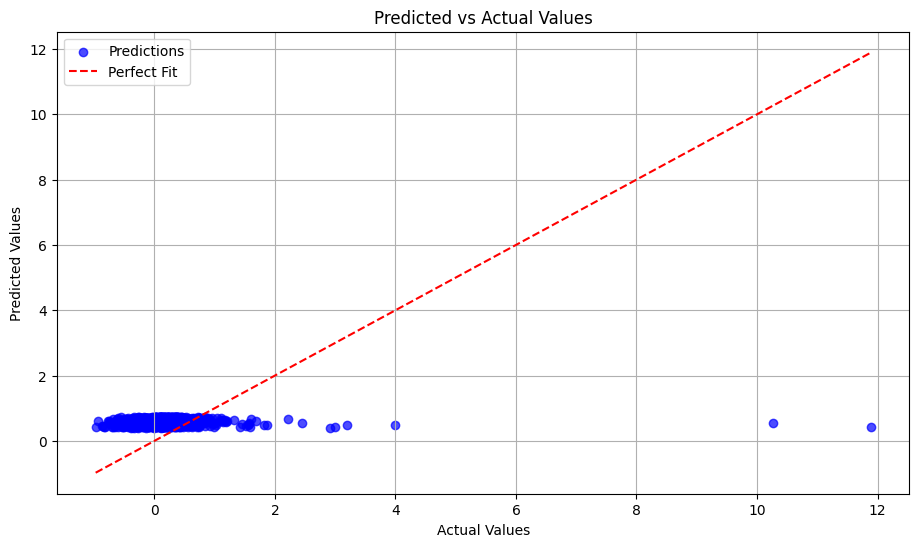

In [77]:
plt.figure(figsize=(11, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Predictions